In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.dates
from datetime import datetime
import random
import numpy as np
from datetime import datetime
import pandas as pd

In [47]:
data_dtypes = {'Store':int,'DayOfWeek':int,'Date':datetime,'Sales':int,'Customers':int,'Promo':int,
               'StateHoliday':str, 'SchoolHoliday':int}
store_dtypes = {'Store':int,'StoreType':str,'Assortment':str,'CompetitionDistance':str,
                'CompetitionOpenSinceMonth':str,'CompetitionOpenSinceYear':str,'Promo2':int,
                'Promo2SinceWeek':str,'Promo2SinceYear':str,'PromoInterval':list}
train_df = pd.read_csv('~/Development/kaggle/rossman/data/train.csv',
                        dtype=data_dtypes,
                        parse_dates=[2]
                        )
test_df = pd.read_csv('~/Development/kaggle/rossman/data/test.csv',
                       dtype=data_dtypes,
                       parse_dates=[3]
                       )
store_df = pd.read_csv('~/Development/kaggle/rossman/data/store.csv',
                        quotechar='"',
                        dtype=store_dtypes
                        )
store_df = store_df.fillna('')
train_df.Open.fillna(1, inplace=True)

In [48]:
def recodeCategorical_asInt(df, fn, newfn):
    df[newfn] = pd.Categorical.from_array(df[fn]).codes
    return df

In [49]:
# Categorical variables
store_df = recodeCategorical_asInt(store_df, 'StoreType', 'StoreTypeVal')
store_df = recodeCategorical_asInt(store_df, 'Assortment', 'AssortmentVal')
store_df = recodeCategorical_asInt(store_df, 'PromoInterval', 'PromoIntervalVal')

In [50]:
# calculate the mean sales of the stores by day of week and overall
stores = {}
for store in train_df.Store.unique():
    sales_by_dow = []
    for dow in train_df.DayOfWeek.unique():
        sales = train_df[(train_df.DayOfWeek == dow) & (train_df.Store == store)].Sales.mean()
        sales_by_dow.append([dow, sales])
    sales_by_dow.append([0, train_df[(train_df.Store == store)].Sales.mean()])
    stores[store] = sales_by_dow

In [51]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 13 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null object
CompetitionOpenSinceMonth    1115 non-null object
CompetitionOpenSinceYear     1115 non-null object
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null object
Promo2SinceYear              1115 non-null object
PromoInterval                1115 non-null object
StoreTypeVal                 1115 non-null int8
AssortmentVal                1115 non-null int8
PromoIntervalVal             1115 non-null int8
dtypes: int64(2), int8(3), object(8)
memory usage: 99.1+ KB


In [87]:
x = [0]
y = [0]
c = [0]
for store in stores.keys():
    x.append(store)
    y.append(next(x for x in stores[store] if x[0]==0)[1])
    c.append(store_df[store_df.Store == store].AssortmentVal.item())


<function matplotlib.pyplot.show>

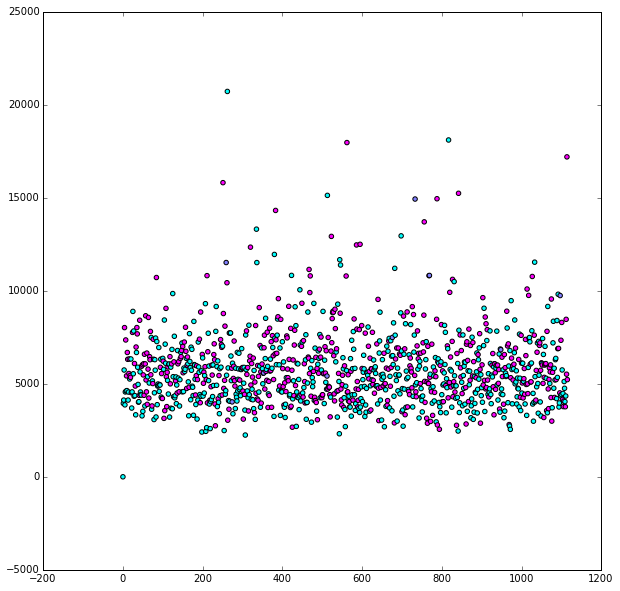

In [88]:
fig = plt.figure(figsize=(10,10))
p = plt.subplot(1,1,1)
plt.scatter(x, y, c=c, cmap=plt.cm.cool)
plt.show

In [39]:
stores

{1: [(5, 4516.4148148148151),
  (4, 4094.6074074074072),
  (3, 4454.4740740740745),
  (2, 4650.9185185185188),
  (1, 4946.1194029850749),
  (7, 0.0),
  (6, 4942.9701492537315),
  (0, 3945.7048832271762)],
 2: [(5, 4462.051851851852),
  (4, 4673.103703703704),
  (3, 5705.2814814814819),
  (2, 5329.4296296296297),
  (1, 5790.5223880597014),
  (7, 0.0),
  (6, 2873.1044776119402),
  (0, 4122.9915074309974)],
 3: [(5, 6820.2222222222226),
  (4, 6371.2444444444445),
  (3, 6973.6888888888889),
  (2, 7588.2148148148144),
  (1, 7965.0298507462685),
  (7, 0.0),
  (6, 4434.6417910447763),
  (0, 5741.2537154989386)],
 4: [(5, 9049.5037037037036),
  (4, 8535.2222222222226),
  (3, 8721.7629629629628),
  (2, 9340.2000000000007),
  (1, 10365.686567164179),
  (7, 0.0),
  (6, 10113.447761194029),
  (0, 8021.7696390658175)],
 5: [(5, 4606.1555555555551),
  (4, 4431.4296296296297),
  (3, 5019.0444444444447),
  (2, 5071.8444444444449),
  (1, 5834.8805970149251),
  (7, 0.0),
  (6, 2079.1044776119402),
  (0,

Use some of the training set to make a mini training set...

The test_df doesn't contain label information, so we need to make our own test data set from the training data

In [247]:
#sample 20% of the train_data dataframe
sample_stores = random.sample(store_df.index, len(store_df)/20)
dev_train_df = train_df[train_df['Store'].isin(sample_stores)]

# Remove the mini_train data from the train dataframe
train_df = train_df[~train_df['Store'].isin(sample_stores)]

# use 10% for a dev_test data set
sample_stores = random.sample(store_df.index, len(store_df)/10)
dev_test_df = train_df[train_df['Store'].isin(sample_stores)]
train_df = train_df[~train_df['Store'].isin(sample_stores)]

In [248]:
#extract NumPy arrays from the Pandas Dataframes and convert the features array
dev_train_labels = dev_train_df['Sales'].values
feature_columns = ['Store',
                   'DayOfWeek',
#                   'Date',
                   'Customers',
                   'Promo',
#                   'StateHoliday',
                   'SchoolHoliday'
                  ]

dev_train_features = dev_train_df.drop('Sales',1)[feature_columns].values

dev_test_labels   = dev_test_df['Sales'].values
dev_test_features = dev_test_df.drop('Sales',1)[feature_columns].values

In [249]:
test_data_mean = np.mean(dev_train_labels, dtype=np.int64)
dev_train_labels = dev_train_labels - test_data_mean
dev_test_labels = dev_test_labels - test_data_mean

In [250]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = 10
clf = KNeighborsClassifier(neighbors)
clf.fit(dev_train_features, dev_train_labels)
accuracy = clf.score(dev_test_features, dev_test_labels)
print 'Accuracy = %.4f' %(accuracy)

Accuracy = 0.1693


In [251]:
from sklearn.linear_model import LinearRegression


In [252]:
clf = LinearRegression()
clf.fit(dev_train_features, dev_train_labels)
print ('Coefficients: \n', clf.coef_)
print ('Residual sum of squares: %.2f' % np.mean((clf.predict(dev_test_features) - dev_test_labels) **2))
print ('variance score: %.2f' % clf.score(dev_test_features, dev_test_labels))

('Coefficients: \n', array([  5.04203138e-01,  -4.99957468e+01,   8.45903139e+00,
         9.96562234e+02,   7.81632863e+00]))
Residual sum of squares: 2649164.14
variance score: 0.79
